In [58]:
import pandas 
import screed
pandas.options.display.max_rows = 1000 
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import sqrt, diag, exp, linspace, log
from scipy.optimize import curve_fit 

# collect all the data and concatenate into a single dataframe 
#!cut -d, -f1-9 Bagel\ Data\ Reporting/Plate*csv | tr A-Z a-z | sort -ur | tail -n +2 > Bagel\ Data\ Reporting/cleaned_data.csv
#also had to remove a few empty rows and remove spaces from sample names

df = pandas.read_csv( 'cleaned_data.csv' )
orig_len = len( df )
df.columns = [ 'plate', 'mutant', 'a280', 'dilution', 'well', 'maxv', 'kobs', 's', 'correction' ]
df['rate'] = ( df.maxv - df.correction ) * 0.0002 / ( df.a280 * df.dilution * 0.25 / 113330 ) 
print '{} observations from {} plates'.format( len( df ), len( df.plate.unique() ) )
df = df[( df['maxv'] > 0 )] # throw away negative rates 
print 'tossing {} observations where rate is negative'.format( orig_len - len( df ) )

# clean up the off-by-threes
for record in screed.open( '/Users/alex/Documents/bagel-orders/wt_fasta/bglb.pep' ):
    seq = record.sequence
    
uniq_names = df['mutant'].unique()
print '{} unique sample names (including WTs)'.format( len( uniq_names ) )

fixer_dict = { }
still_wrong = [ ]

for m in uniq_names:
    if 'wt' in m or '_' in m or '+' in m:
        fixer_dict.update( { m: m } )
    elif seq[ int( m[1:-1] ) - 1 ].lower() == m[0]: # correct 
        fixer_dict.update( { m: m } )
    elif seq[ int( m[1:-1] ) - 4 ].lower() == m[0]: # off by three
        new_index = '{0}{2}{1}'.format( m[0], m[-1], int( m[1:-1] ) - 3 )
        fixer_dict.update( { m: new_index } ) 
    else:
        still_wrong.append( m )
            
custom_map = { 'e53a': 'e353a', 'e17s': 's17e', 'm223g': 'm323g',  }

if custom_map:
    print 'Updating fixer map with', custom_map
    fixer_dict.update( custom_map )
else:
    print 'No map provided for {}'.format( still_wrong )

def fixer( x ):
    return fixer_dict[ x ]

df.mutant = df.mutant.map( fixer, na_action='ignore' )
df.head()

3240 observations from 35 plates
tossing 311 observations where rate is negative
132 unique sample names (including WTs)
Updating fixer map with {'e17s': 's17e', 'e53a': 'e353a', 'm223g': 'm323g'}


,plate,mutant,a280,dilution,well,maxv,kobs,s,correction,rate
0,9,l219a,0.473,0.01,h3,0.000048,0.917734,0.00000,4.260000e-07,0.909975
3,9,l219a,0.473,0.01,g3,0.000046,0.882883,0.00002,3.650000e-07,0.876642
4,9,l219a,0.473,0.01,g2,0.000050,0.952585,0.00002,3.650000e-07,0.945647
5,9,l219a,0.473,0.01,g1,0.000077,1.475345,0.00002,3.650000e-07,1.468929
6,9,l219a,0.473,0.01,f3,0.000125,2.404696,0.00007,4.120000e-07,2.397670


Fit 98 of 119 samples to MM equation


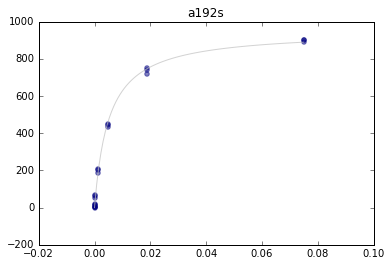

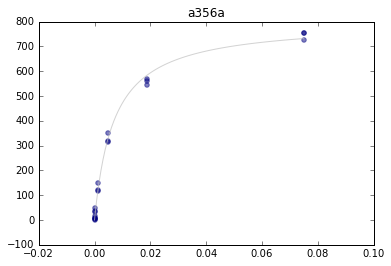

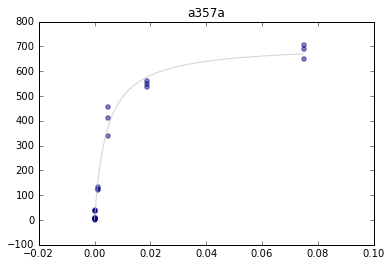

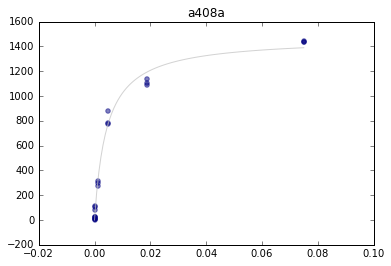

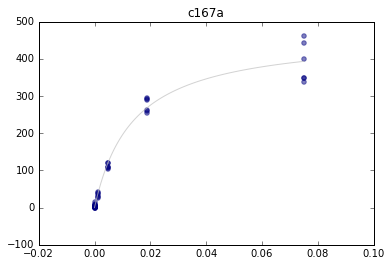

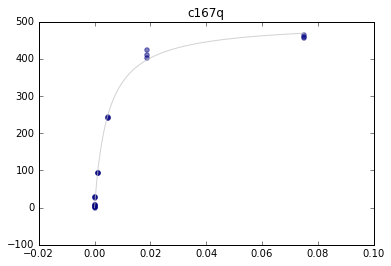

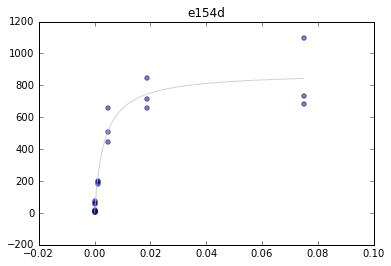

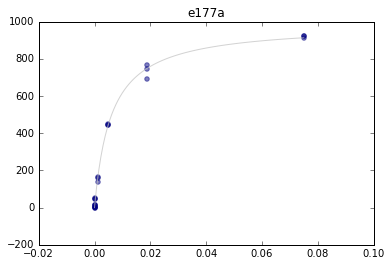

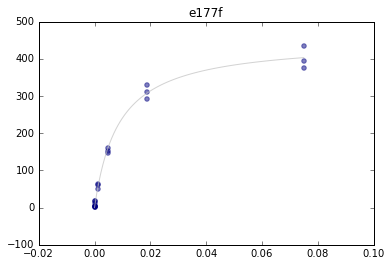

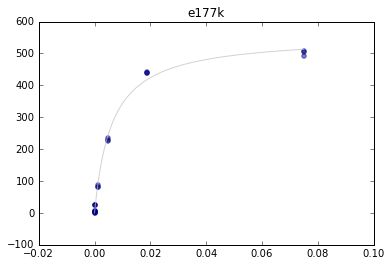

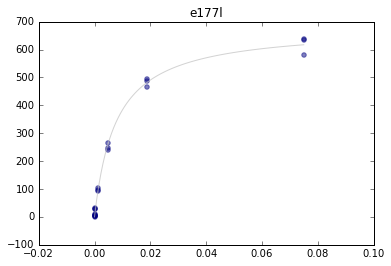

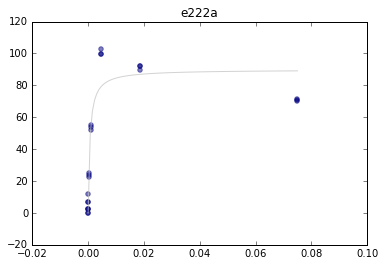

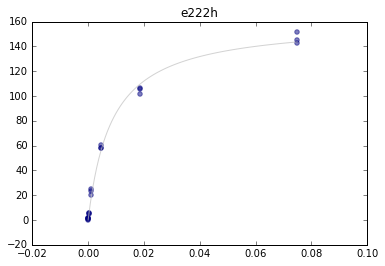

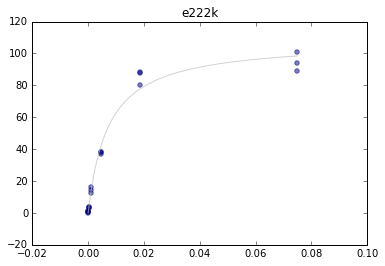

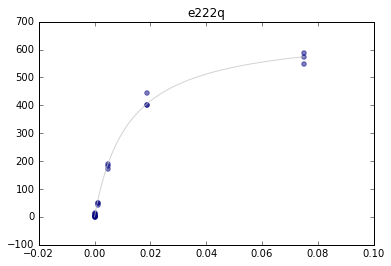

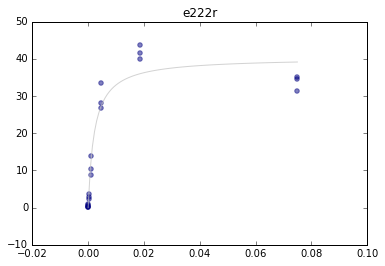

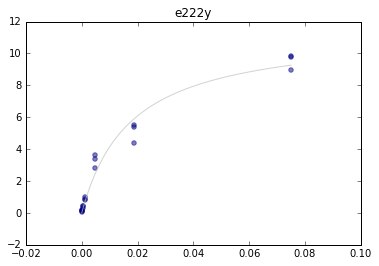

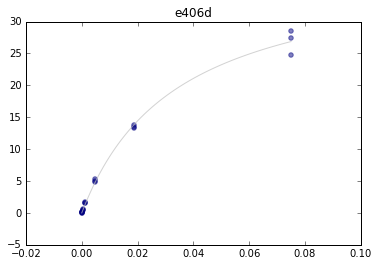

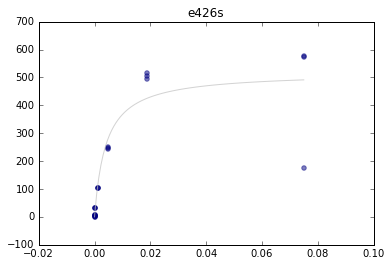

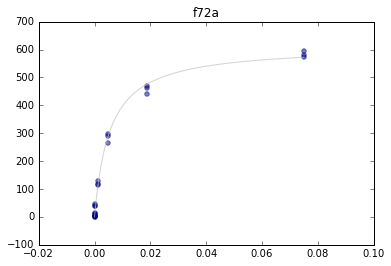

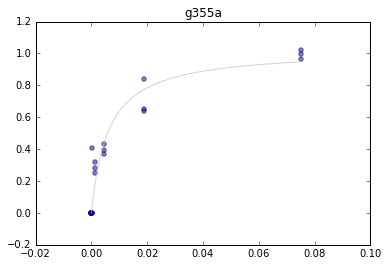

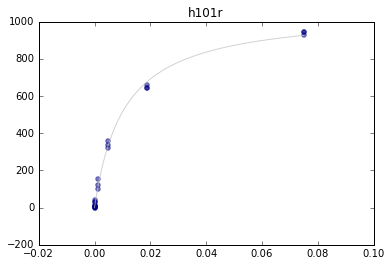

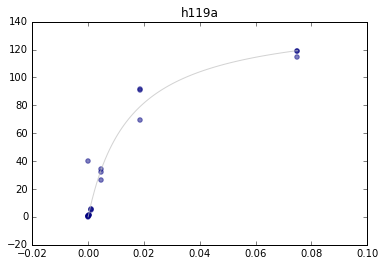

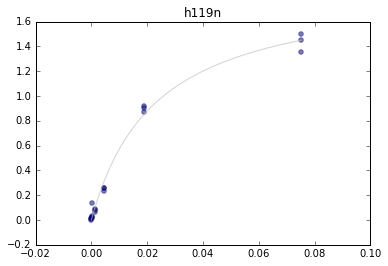

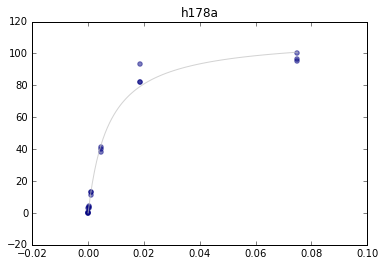

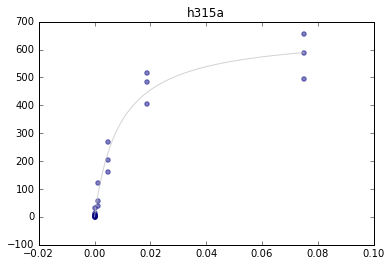

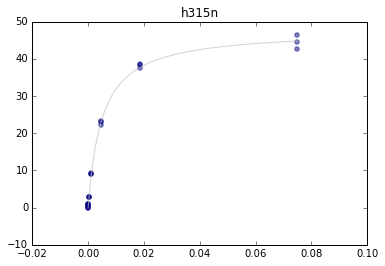

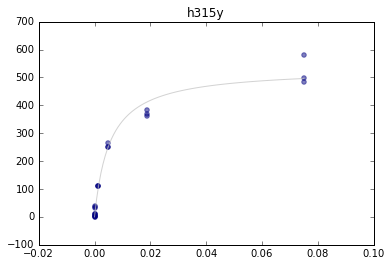

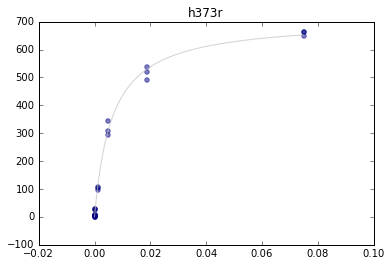

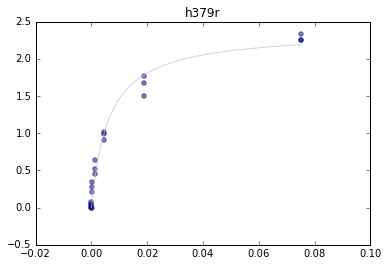

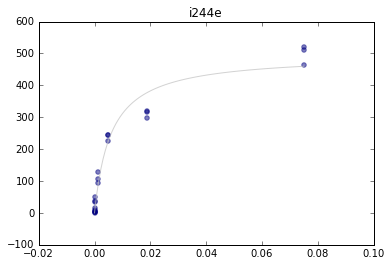

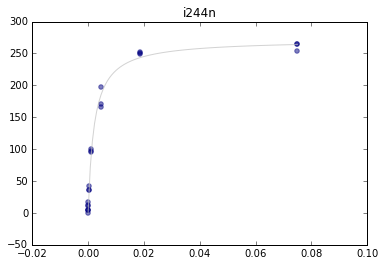

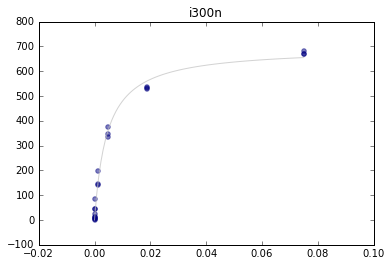

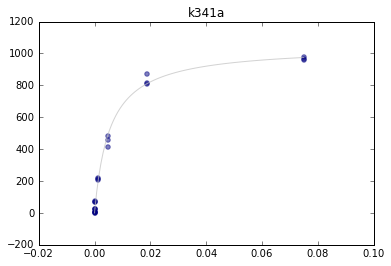

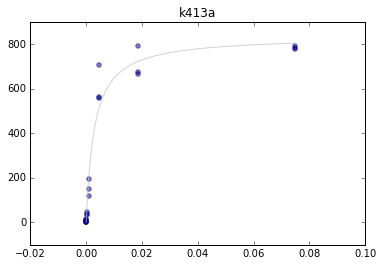

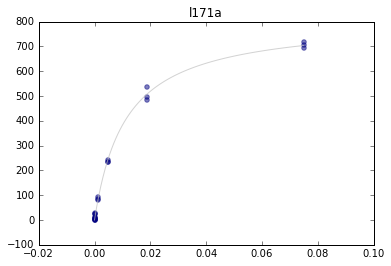

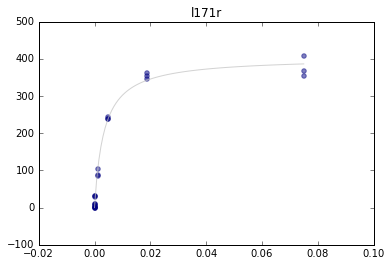

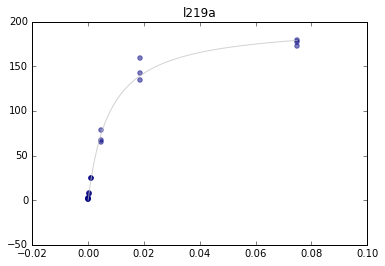

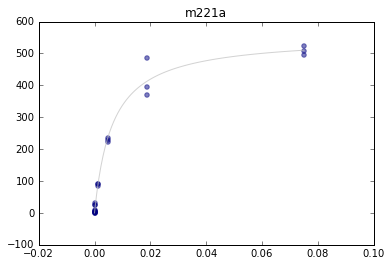

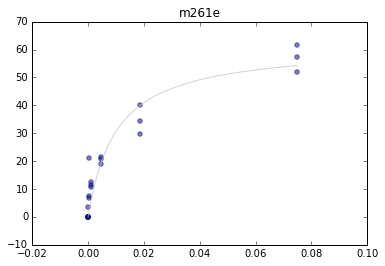

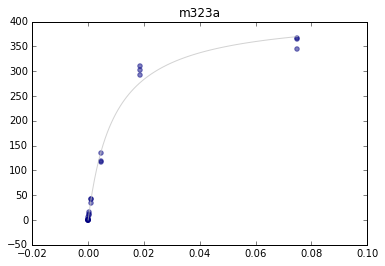

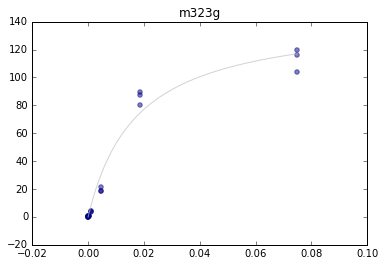

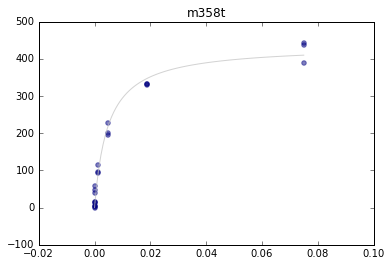

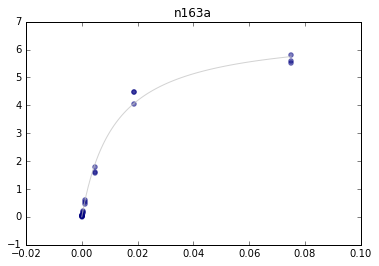

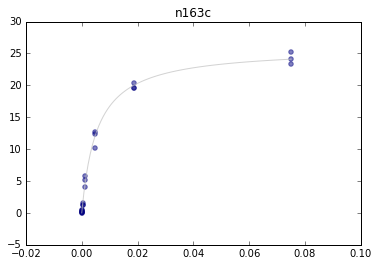

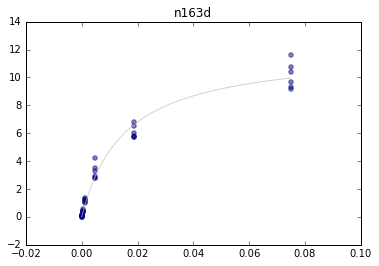

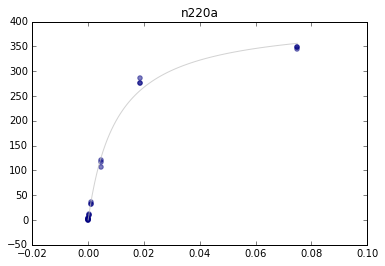

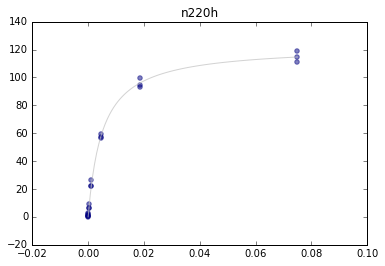

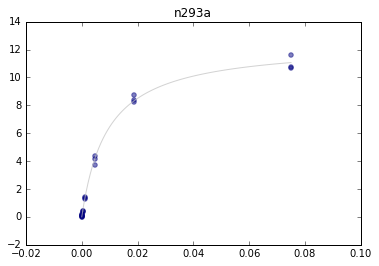

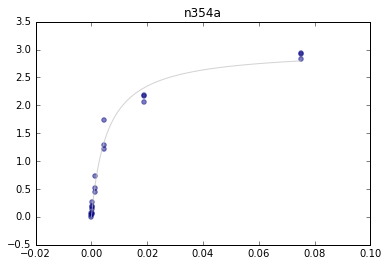

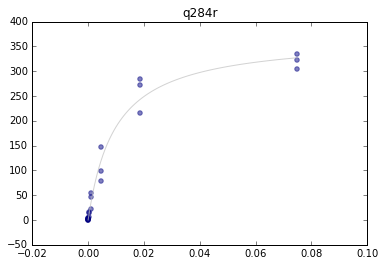

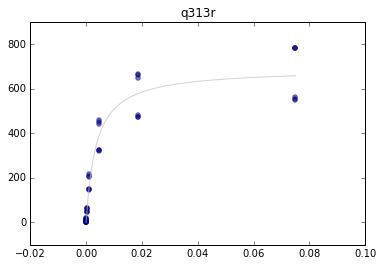

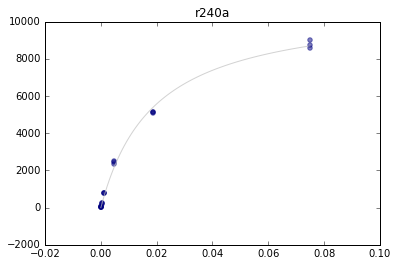

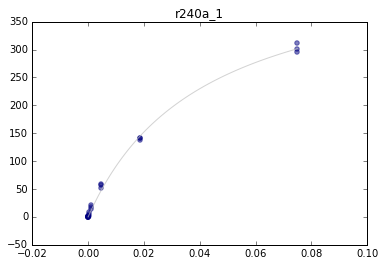

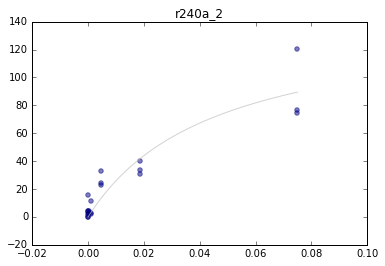

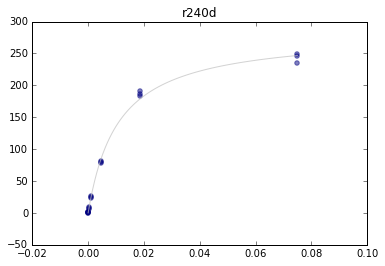

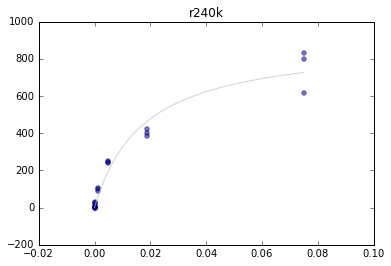

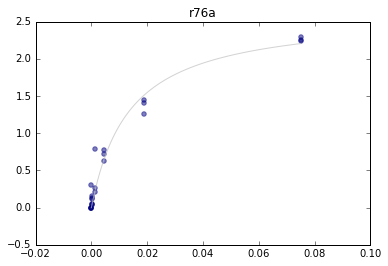

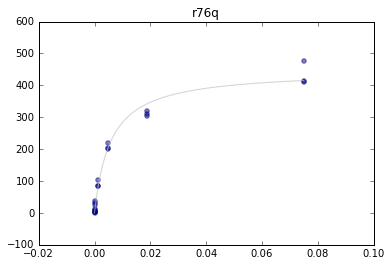

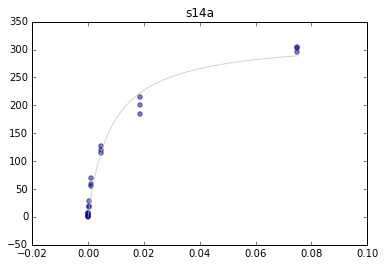

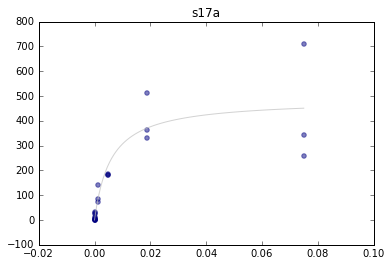

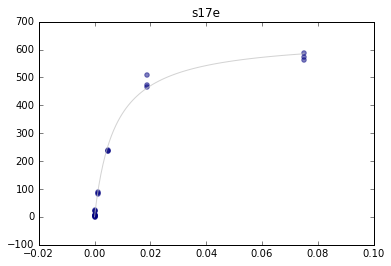

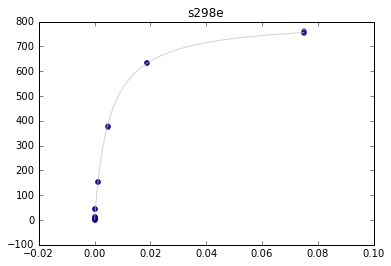

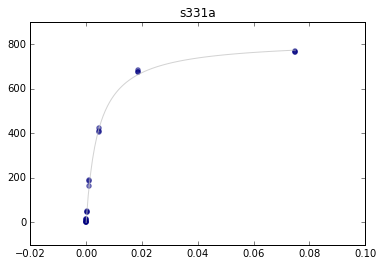

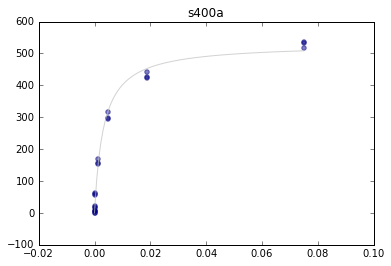

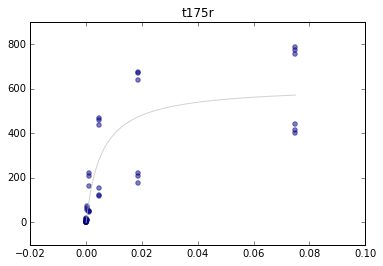

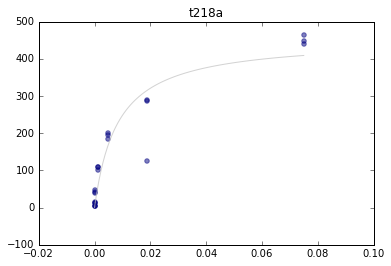

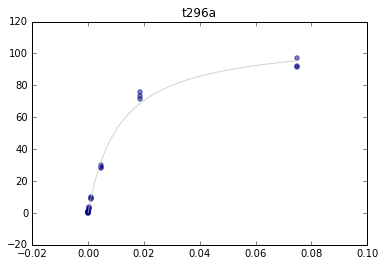

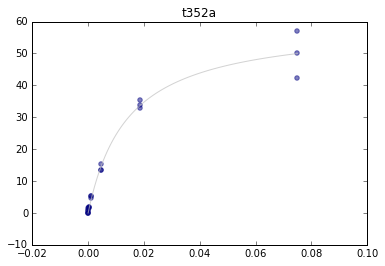

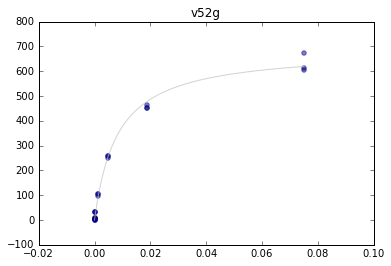

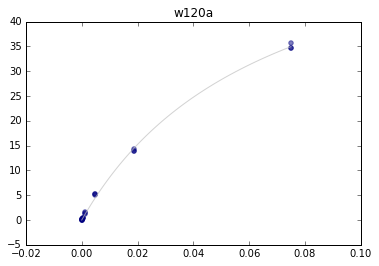

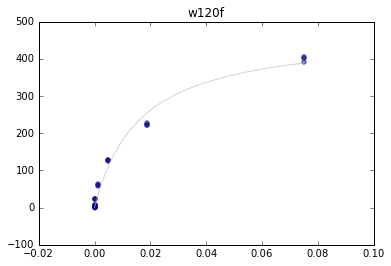

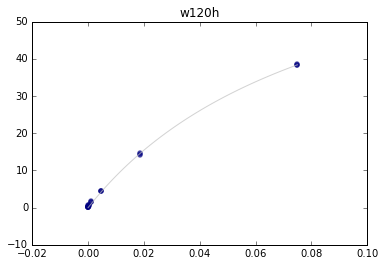

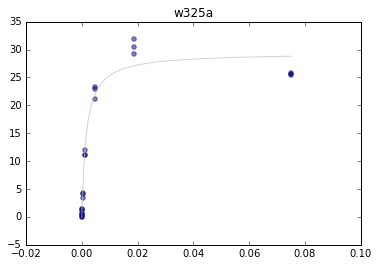

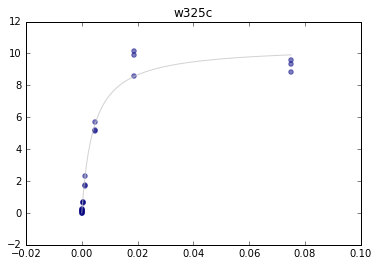

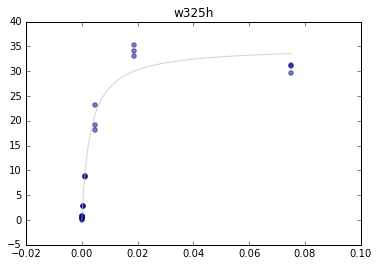

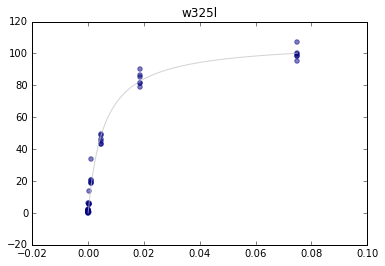

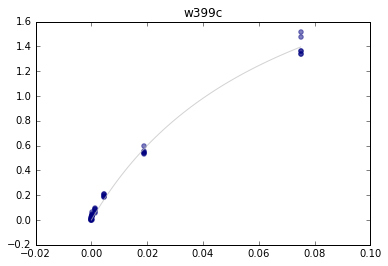

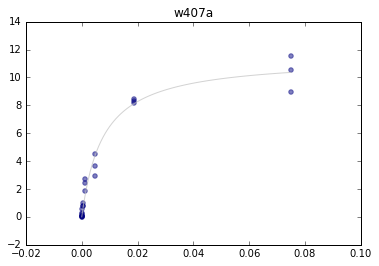

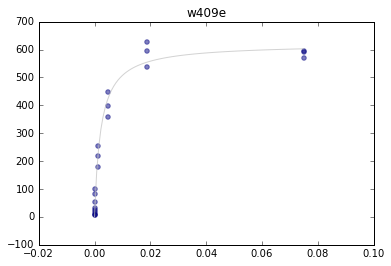

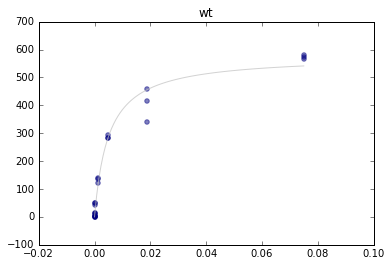

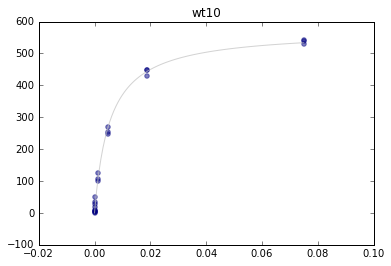

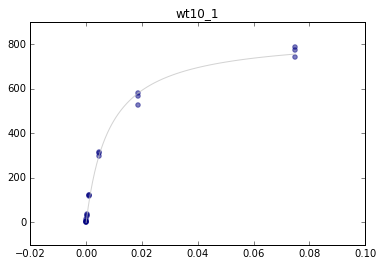

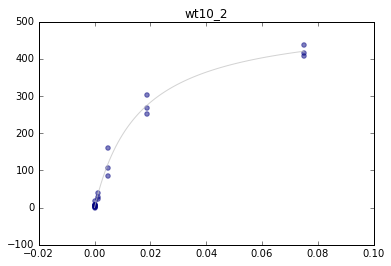

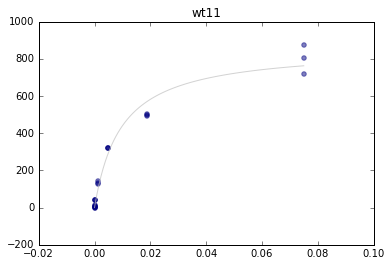

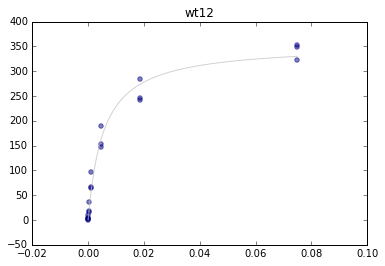

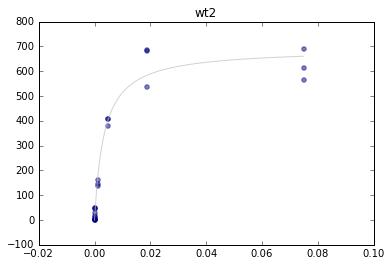

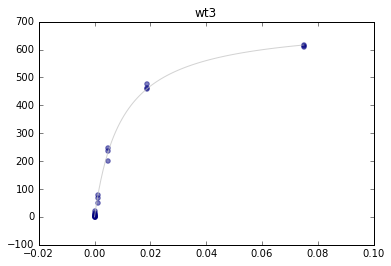

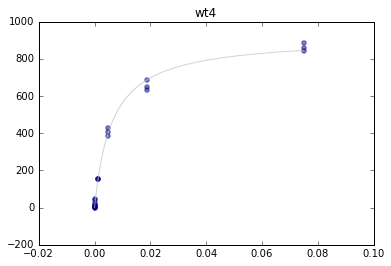

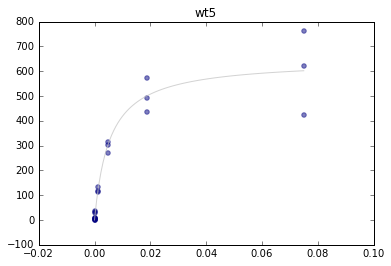

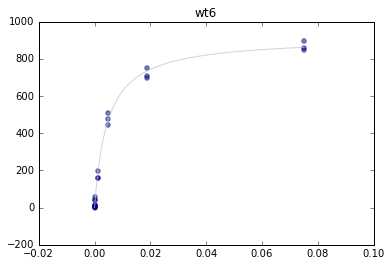

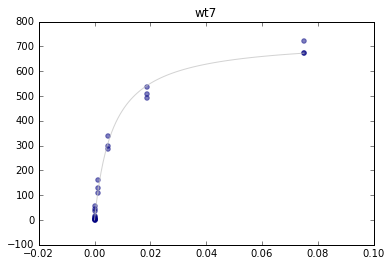

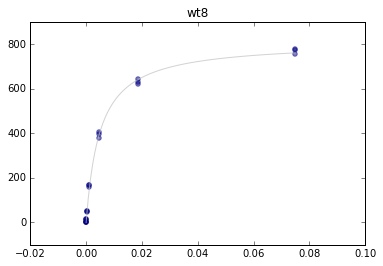

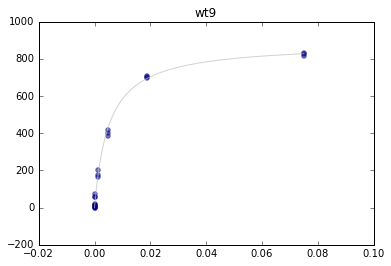

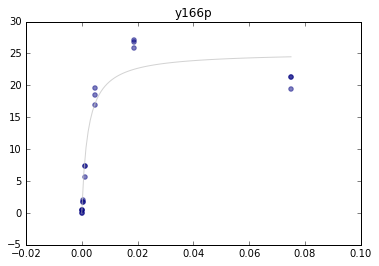

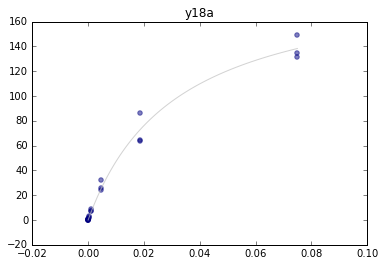

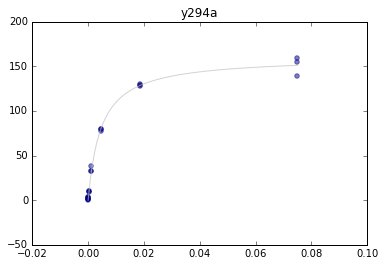

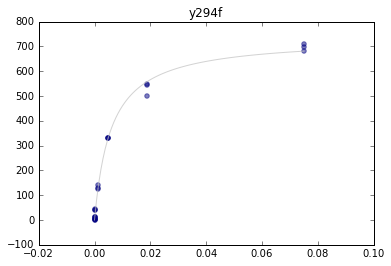

In [59]:
def v( x, kcat, km ): 
    return kcat * x / ( km + x )

mms = [ ]
others = [ ]
grouped = df.groupby( 'mutant' )

for name, df in grouped:
    try:
        p0 = ( df.rate.max(), df.s.mean() )
        popt, pcov = curve_fit( v, df.s, df.rate, p0=p0 )
        perr = sqrt( diag( pcov ) ) / popt * 100 
        
        # check params 
        if popt[0] > 1 and .00005 < popt[1] < .1:
            # check errors 
            if perr[0] < 50 and perr[1] < 50:
                mms.append( ( name, df ) )
                fig, ax = plt.subplots()
                ax.scatter( df.s, df.rate, alpha=0.5, color='navy' )
                xvalues = linspace( 0, 0.075, 99 )
                ax.plot( xvalues, v( xvalues, *popt ), alpha=0.7, color='silver' )
                ax.set_title( name )
                fig.savefig( 'plots/{}.png'.format( name ) )
        else:
            others.append( ( name, df ) )
    except Exception as e:
        print e 
            
print 'Fit {} of {} samples to MM equation'.format( len( mms ), len( mms ) + len( others ) )

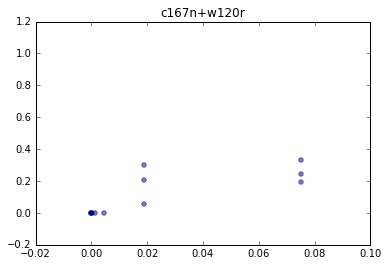

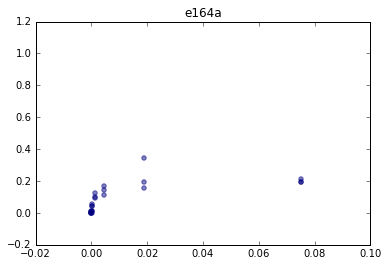

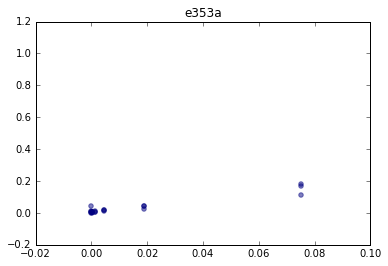

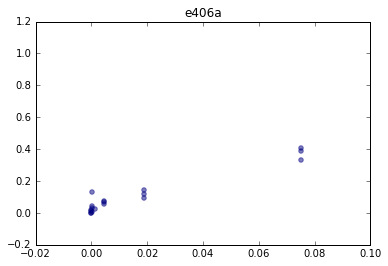

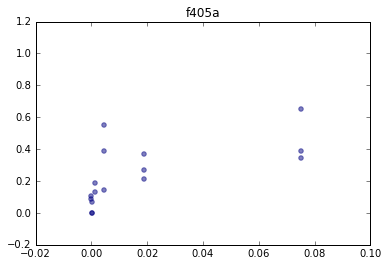

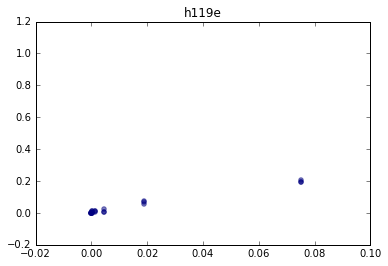

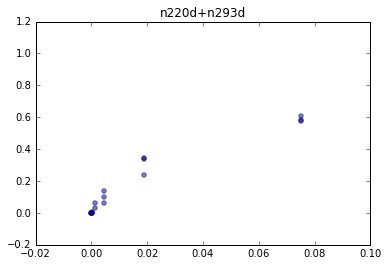

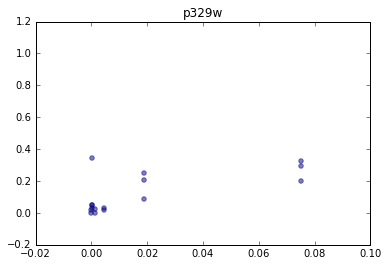

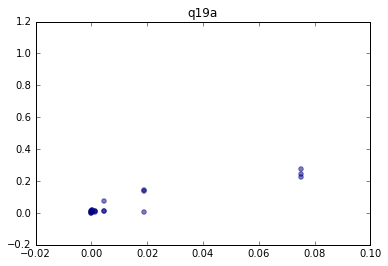

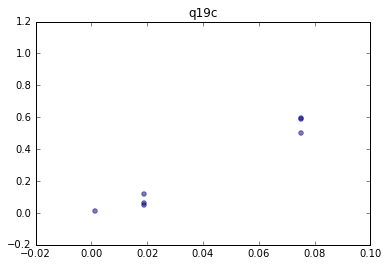

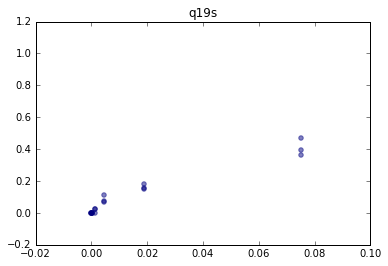

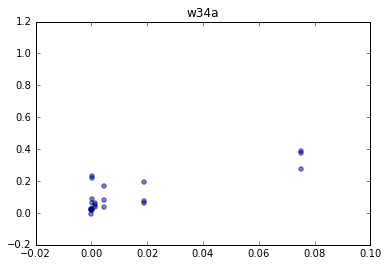

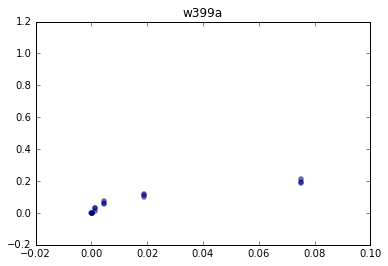

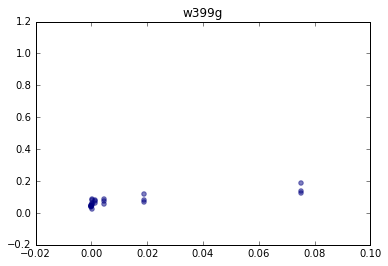

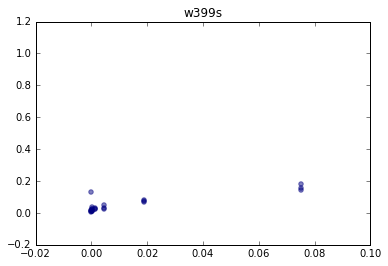

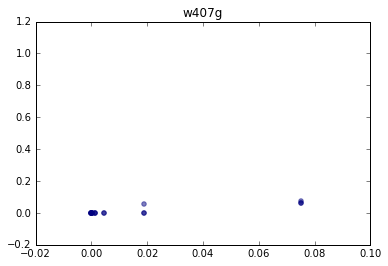

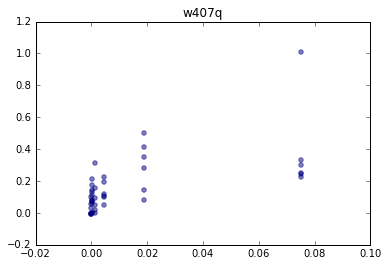

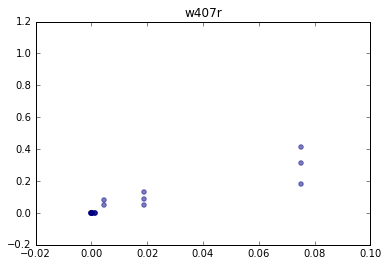

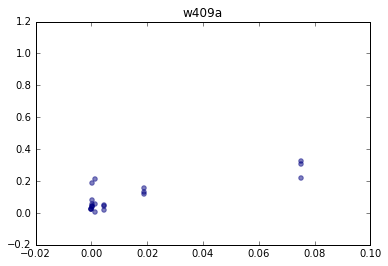

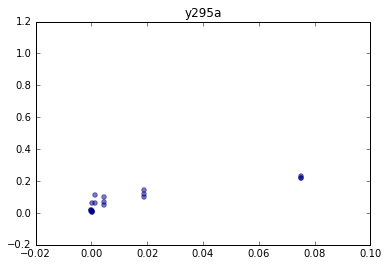

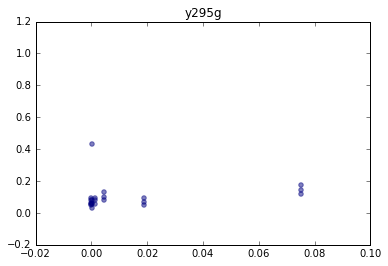

In [60]:
for name, df in others:
    plt.scatter( df.s, df.rate, alpha=0.5, color='navy' )
    plt.ylim( -.2, 1.2 )
    plt.title( name )
    plt.show()